In [1]:
import pandas as pd
import numpy as np
import re
import datetime

# Read Files

## Player + Playtime data

In [5]:
#Define how many days injured in a season constitutes 'major_injury' (this will alter the target variable of the model)
injury_threshold = 120

In [7]:
#Filter data between these seasons. 
start_season = 2016 
end_season = 2020

#above corresponds to 2016/17 to 2020/21 seasons (5 in total)

In [9]:
# Read player, player_stats, match csv files
player = pd.read_csv('data/player.csv', encoding='ISO-8859-1')

player_stats = pd.read_csv('data/player_stats.csv')


match = pd.read_csv('data/match.csv')[['match_id', 'match_date', 'season']]
match = match.loc[match.match_date!='0000-00-00'] #remove erroneous data #only 1 row
match['start_year'] = match['season'].str[:4].astype(int) #create start_year column
match['match_date'] = pd.to_datetime(match['match_date']) #convert to date
match = match.drop(columns = 'season') #drop season column

In [11]:
player_stats

,player_id,match_id,is_in_starting_11,substitution_on,substitution_off,yellow_card,red_card,is_home_side
0,p1,4,1,Null,Null,Null,Null,0
1,p1,12,1,Null,Null,Null,Null,1
2,p1,24,1,Null,Null,Null,Null,1
3,p1,41,1,Null,Null,Null,Null,0
4,p1,46,1,Null,83',True,Null,0
...,...,...,...,...,...,...,...,...
356460,p999,7462,0,70',Null,Null,Null,1
356461,p999,7493,0,86',Null,True,Null,1
356462,p999,7549,0,Null,Null,Null,Null,1
356463,p999,7577,0,Null,Null,Null,Null,0


In [13]:
# Remove non-numeric characters from the substitution_on/off columns

player_stats['substitution_on'] = player_stats['substitution_on'].str.replace("'", "")
player_stats['substitution_off'] = player_stats['substitution_off'].str.replace("'", "")

def convert_minute(minute_str):
    if pd.isna(minute_str):
        return np.nan
    elif minute_str == 'Null':
        return np.nan
    elif '+' in minute_str:
        minute_str = minute_str.split('+')[1].strip()
        minute_int = int(minute_str) + 90
    else:
        minute_int = int(minute_str)
    return minute_int


player_stats['substitution_on'] = player_stats['substitution_on'].apply(convert_minute)
player_stats['substitution_off'] = player_stats['substitution_off'].apply(convert_minute)



In [15]:
#Merge player_stats to get player_name
player['p_id2'] = player['player_name'].str.lower().str.replace(' ', '')

player1 = pd.merge(player_stats,player[['p_id2', 'player_name', 'position', 'player_id']], on='player_id', how='left')

#Merge player1 with match table to get date of each game played
player2 = pd.merge(player1, match, on ='match_id', how = 'left')

In [17]:
#Filter between seasons we are analysing
player2 = player2.loc[player2.start_year.between(start_season, end_season)]

Check here for players with the same name

In [20]:
def calculate_minutes_played(row):
    if row['is_in_starting_11'] == 1 and pd.isnull(row['substitution_off']):
        return 95 #Average of 5 additional minutes
    elif row['is_in_starting_11'] == 1 and pd.notnull(row['substitution_off']):
        return row['substitution_off']
    elif row['is_in_starting_11'] == 0 and pd.isnull(row['substitution_on']):
        return 0
    elif row['is_in_starting_11'] == 0 and pd.notnull(row['substitution_on']) and pd.isnull(row['substitution_off']):
        return 95 - row['substitution_on']
    elif row['is_in_starting_11'] == 0 and pd.notnull(row['substitution_on']) and pd.notnull(row['substitution_off']):
        return row['substitution_off'] - row['substitution_on']
    
player2['minutes_played'] = player2.apply(calculate_minutes_played, axis=1)

#Create game_played column which is 1 if minutes_played is more than 0
player2['game_played'] = player2['minutes_played'].apply(lambda x: 1 if x > 0 else 0) 

#change negative values to 0
player2['minutes_played'] = player2['minutes_played'].apply(lambda x: 0 if x < 0 else x) 

#Take relevant columns
player3 = player2[['p_id2', 'position' ,'match_id','match_date', 'start_year','minutes_played','game_played']]

In [21]:
player3.head()

,p_id2,position,match_id,match_date,start_year,minutes_played,game_played
509,albertomoreno,Defender,14040,2016-08-14,2016.0,95.0,1
510,albertomoreno,Defender,14051,2017-03-12,2016.0,0.0,0
511,albertomoreno,Defender,14067,2016-08-27,2016.0,0.0,0
512,albertomoreno,Defender,14073,2016-09-10,2016.0,2.0,1
513,albertomoreno,Defender,14080,2016-09-16,2016.0,0.0,0


## Injury data

In [25]:
injuries = pd.read_csv('data/injuries.csv', encoding='ISO-8859-1')

# Remove non-alphabetic characters and convert to lowercase
injuries['p_id2'] = injuries['player_name'].replace('[^a-zA-Z]+', '', regex=True).str.lower()

# extract player name by removing all unneccessary characters
# injuries['player_name'] = injuries['player_url'].str.split(
#     '.com/').str[1].str.split('/profil').str[0].str.replace('-', ' ')

# #create own player id for us to join other tables later
# injuries['p_id3'] = injuries['player_name'].str.replace(' ', '')

#remove nulls
injuries = injuries.loc[injuries['season_injured'].notna()]

#add start_year column
injuries['start_year'] = ('20' + injuries['season_injured'].str[:2]).astype(int)


# Define a function to extract integers from the duration column
def extract_duration(row):
    duration_str = row['duration']
    match = re.search(r'\d+', duration_str)
    if match:
        return int(match.group())
    else:
        return 0
# Apply the function to create a new column with integer values
injuries['duration'] = injuries.apply(extract_duration, axis=1)

#Remove injuries which are sicknesses 
injuries = injuries.loc[~injuries.injury.isin(['Corona virus', 'Ill', 'Cold','Food Poisoning', 'Quarantine'])]

#Filter only injuries between start and end year

injuries = injuries.loc[injuries.start_year.between(start_season,end_season)]

#take relevant columns
injuries = injuries[['p_id2','start_year', 'injury',
       'injured_since', 'injured_until', 'duration']]

In [27]:
# Grouping player_dataframe by player_id
# group by p_id2 and start_year and aggregate by summing minutes_played and counting number of rows
injuries_grouped = injuries.groupby(['p_id2', 'start_year']).agg({'duration': 'sum'})

# rename the columns and reset index
injuries_grouped = injuries_grouped.rename(columns={'duration': 'season_days_injured'})
injuries_grouped = injuries_grouped.reset_index()

# create total minutes played column
total_days_injured = injuries.groupby('p_id2').agg({'duration': 'sum'}).rename(
    columns={'duration': 'total_days_injured'})

# merge the total minutes and games played columns with the grouped dataframe
injuries_grouped = injuries_grouped.merge(total_days_injured, on='p_id2')
df_injuries = injuries_grouped
df_injuries

,p_id2,start_year,season_days_injured,total_days_injured
0,aaronconnolly,2018,77,161
1,aaronconnolly,2019,13,161
2,aaronconnolly,2020,71,161
3,aaroncresswell,2016,95,226
4,aaroncresswell,2018,87,226
...,...,...,...,...
3105,zlatanibrahimovic,2016,210,579
3106,zlatanibrahimovic,2017,84,579
3107,zlatanibrahimovic,2018,36,579
3108,zlatanibrahimovic,2019,39,579


## Fifa Data

In [30]:
fifa_16 = pd.read_csv('data/players_16.csv')
fifa_17 = pd.read_csv('data/players_17.csv')
fifa_18 = pd.read_csv('data/players_18.csv')
fifa_19 = pd.read_csv('data/players_19.csv')
fifa_20 = pd.read_csv('data/players_20.csv')
fifa_21 = pd.read_csv('data/players_21.csv')

In [31]:
#Function to extract name from url
def extract_name_url(df):
    # Copy the original DataFrame to avoid modifying it directly
    new_df = df.copy()
    
    # Extract the name from the player_url using a regular expression
    pattern = r'/player/\d+/(.*)/'
    new_df['p_id2'] = df['player_url'].apply(lambda x: re.findall(pattern, x)[0])
    
    # Remove any non-alphabetic characters and convert to lowercase
    new_df['p_id2'] = new_df['p_id2'].apply(lambda x: re.sub('[^a-zA-Z]', '', x.lower()))
    
    return new_df

#Function to apply extract_name_url and take relevant columns 

def clean_fifa_data(df):
    
    #Filter relevant columns only
    relevant_cols = ['sofifa_id', 'player_url', 'dob', 'height_cm', 'weight_kg', 'nationality', 'work_rate',
                    'pace', 'physic', 'overall']
    df = df[relevant_cols]
    df = extract_name_url(df)
    return df

In [34]:
#Apply functions
fifa_16 = clean_fifa_data(fifa_16)
fifa_17 = clean_fifa_data(fifa_17)
fifa_18 = clean_fifa_data(fifa_18)
fifa_19 = clean_fifa_data(fifa_19)
fifa_20 = clean_fifa_data(fifa_20)
fifa_21 = clean_fifa_data(fifa_21)

In [36]:
#Take average for all fifa df's and combine into 1 df

# Concatenate all the dataframes into a single dataframe
fifa_all = pd.concat([fifa_16, fifa_17, fifa_18, fifa_19, fifa_20, fifa_21])

# Group the concatenated dataframe by sofifa_id
grouped = fifa_all.groupby('sofifa_id')

# Compute the mean of float/int columns and the mode of non-numeric columns for each group
aggregated = grouped.agg(lambda x: x.mean() if x.dtype=='float64' or x.dtype=='int64' else x.mode()[0])

# Create a new dataframe called 'fifa' using the aggregated data
fifa = pd.DataFrame(aggregated.to_records())

# Rename columns as needed
fifa = fifa.rename(columns={'index': 'sofifa_id', 'overall': 'fifa_rating'})

#take only relevant columns
fifa = fifa[['p_id2','dob', 'height_cm', 'weight_kg',
       'nationality', 'work_rate', 'pace', 'physic', 'fifa_rating']]

In [38]:
fifa.head()

,p_id2,dob,height_cm,weight_kg,nationality,work_rate,pace,physic,fifa_rating
0,giovannipasquale,1982-01-05,182.000000,72.000000,Italy,Medium/High,71.000000,71.000000,69.000000
1,luisgarciafernandez,1981-02-06,177.666667,66.333333,Spain,Medium/Medium,56.000000,63.333333,70.000000
2,joecole,1981-11-08,176.000000,73.000000,England,High/Low,56.000000,54.000000,72.000000
3,manuelherrerayague,1981-09-29,182.000000,75.000000,Spain,Medium/Medium,NaN,NaN,71.000000
4,andresiniestalujan,1984-05-11,171.000000,68.000000,Spain,High/Medium,68.333333,59.000000,85.666667


# Combining the 3 datasets (add fifa data above)

In [41]:
print('Unique players in player dataframe:',player3.p_id2.nunique())
print('Unique players in injury dataframe:',df_injuries.p_id2.nunique())
print('Unique players in FIFA dataframe:', fifa.p_id2.nunique())


Unique players in player dataframe: 1411
Unique players in injury dataframe: 1212
Unique players in FIFA dataframe: 37909


In [43]:
# List of players to be included in our analysis
player_list = injuries['p_id2'].tolist() 

#Filter player and fifa dataframes to include relevant player_list
player4 = player3.loc[player3.p_id2.isin(player_list)]
fifa2 = fifa.loc[fifa.p_id2.isin(player_list)]

print('Unique players on all 3 datasets:',pd.merge(
    player4,injuries, on='p_id2' ,how = 'inner').merge(fifa2, on = 'p_id2', how = 'inner').p_id2.nunique())


Unique players on all 3 datasets: 738


In [45]:
# Grouping player_dataframe by player_id
# group by p_id2 and start_year and aggregate by summing minutes_played and counting number of rows
grouped = player4.groupby(['p_id2', 'start_year']).agg({'minutes_played': 'sum', 'game_played': 'sum', 'match_id': 'count'})

# rename the columns
grouped = grouped.rename(columns={
    'minutes_played': 'season_minutes_played', 'game_played': 'season_games_played', 'match_id':'season_matches_in_squad'})

# reset the index
grouped = grouped.reset_index()

# create total minutes played column
total_minutes_played = player4.groupby('p_id2').agg({'minutes_played': 'sum'}).rename(
    columns={'minutes_played': 'total_minutes_played'})

# create total games played column
total_games_played = player4.groupby('p_id2').agg({'game_played': 'sum'}).rename(columns={'game_played': 'total_games_played'})
    
# merge the total minutes and games played columns with the grouped dataframe
grouped = grouped.merge(total_minutes_played, on='p_id2').merge(total_games_played, on='p_id2')

# Group by p_id2 and start_year
grouped2 = player4.groupby(['p_id2', 'start_year'])

df_playtime = grouped

In [47]:
#Merge relevant dataframes
df1 = df_injuries.merge(df_playtime, on = ['p_id2', 'start_year'], how= 'inner')
df2 = df1.merge(fifa, on ='p_id2', how = 'inner')

#Add column for position
df = df2.merge(player[['p_id2', 'position']], on = 'p_id2', how = 'inner')

print('Final number of players to be analyzed:',df.p_id2.nunique())

Final number of players to be analyzed: 604


In [49]:
df.head()

,p_id2,start_year,season_days_injured,total_days_injured,season_minutes_played,season_games_played,season_matches_in_squad,total_minutes_played,total_games_played,dob,height_cm,weight_kg,nationality,work_rate,pace,physic,fifa_rating,position
0,aaronconnolly,2019,13,161,1312.0,24,28,2148.0,41,2000-01-28,175.333333,75.666667,Republic of Ireland,Medium/Low,72.333333,58.0,63.000000,Forward
1,aaronconnolly,2020,71,161,836.0,17,28,2148.0,41,2000-01-28,175.333333,75.666667,Republic of Ireland,Medium/Low,72.333333,58.0,63.000000,Forward
2,aaroncresswell,2016,95,226,2247.0,26,27,13368.0,149,1989-12-15,171.666667,66.000000,England,High/Medium,74.333333,67.0,75.333333,Defender
3,aaroncresswell,2018,87,226,1680.0,20,27,13368.0,149,1989-12-15,171.666667,66.000000,England,High/Medium,74.333333,67.0,75.333333,Defender
4,aaroncresswell,2019,35,226,2870.0,31,31,13368.0,149,1989-12-15,171.666667,66.000000,England,High/Medium,74.333333,67.0,75.333333,Defender


# Feature Engineering

In [52]:
df.reset_index(drop=True, inplace=True) #first reset index

# Calculate age at the beginning of the season
df['age'] = df['start_year'] - df['dob'].str[:4].astype(int)
#df.drop('dob', axis=1, inplace=True)

# Custom function to calculate cumulative minutes and games played
def calculate_cumulative(x):
    return x.shift(1).expanding().sum()

# Calculate minutes per game considering all years prior to the current year
df['cumulative_minutes_played'] = df.groupby('p_id2')['season_minutes_played'].apply(calculate_cumulative).reset_index(level=0, drop=True)
df['cumulative_games_played'] = df.groupby('p_id2')['season_games_played'].apply(calculate_cumulative).reset_index(level=0, drop=True)
df['minutes_per_game_prev_seasons'] = df['cumulative_minutes_played'] / df['cumulative_games_played']

# Custom function to calculate average of a Series
def calculate_average(x):
    return x.shift(1).expanding().mean()

# Calculate average days injured per season in previous seasons
df['avg_days_injured_prev_seasons'] = df.groupby('p_id2')['season_days_injured'].apply(calculate_average).reset_index(level=0, drop=True)

# Calculate average games per season in previous seasons
df['avg_games_per_season_prev_seasons'] = df.groupby('p_id2')['season_games_played'].apply(calculate_average).reset_index(level=0, drop=True)

# Calculate the Body Mass Index (BMI)
df['bmi'] = df['weight_kg'] / (df['height_cm'] / 100)**2

#Converting work rate into numeric variable where low = 1, medium = 1.5, high = 2. i.e.- High/medium work rate = 3.5
work_rate_map = {'Low': 1, 'Medium': 1.5, 'High': 2}
df['work_rate_numeric'] = df['work_rate'].apply(lambda x: sum([work_rate_map[w] for w in x.split('/')]))

#Convert position to numeric variable where number corresponds to position intensity (GK -> defender -> forward -> midfielder)
pos_order = {'Goalkeeper': 0, 'Defender': 1, 'Forward': 2, 'Midfielder': 3}
df['position_numeric'] = df['position'].map(pos_order)

# Create a feature indicating if the player had a significant injury in the previous season
#injury_threshold defined previously
prev_season_injury = df.groupby('p_id2')['season_days_injured'].shift(1)
df['significant_injury_prev_season'] = np.where(prev_season_injury.isna(), np.nan, (prev_season_injury >= injury_threshold).astype(int))
df['significant_injury_prev_season'].astype('category')

# Calculate cumulative days injured and days injured in the previous season
df['cumulative_days_injured'] = df.groupby('p_id2')['total_days_injured'].apply(calculate_cumulative).reset_index(level=0, drop=True)
df['season_days_injured_prev_season'] = df.groupby('p_id2')['season_days_injured'].shift(1)

df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [54]:
df.position.unique()

array(['Forward', 'Defender', 'Midfielder', 'Goalkeeper', nan],
      dtype=object)

In [56]:
df.isnull().sum()

p_id2                                  0
start_year                             0
season_days_injured                    0
total_days_injured                     0
season_minutes_played                  0
season_games_played                    0
season_matches_in_squad                0
total_minutes_played                   0
total_games_played                     0
dob                                    0
height_cm                              0
weight_kg                              0
nationality                            0
work_rate                              0
pace                                  95
physic                                95
fifa_rating                            0
position                               2
age                                    0
cumulative_minutes_played            604
cumulative_games_played              604
minutes_per_game_prev_seasons        616
avg_days_injured_prev_seasons        604
avg_games_per_season_prev_seasons    604
bmi             

In [58]:
df.to_csv('df_injury_player_data_features_v1.csv', index = False)

# Analysis

In [61]:
df = pd.read_csv('df_injury_player_data_features_v1.csv')

In [63]:
physical_features = ['p_id2', 'start_year', 'position', 'age',
                     'bmi', 'height_cm', 'weight_kg', 'work_rate_numeric' ,'pace', 'physic',
                     'work_rate', 'position_numeric' ,'season_days_injured']

season_features = ['p_id2', 'start_year', 'cumulative_minutes_played','cumulative_games_played',
                   'minutes_per_game_prev_seasons','avg_days_injured_prev_seasons', 'avg_games_per_season_prev_seasons', 
                  'significant_injury_prev_season', 'cumulative_days_injured','season_days_injured_prev_season',
                   'season_days_injured']

df_physical = df[physical_features]
df_season = df[season_features]

In [65]:
df_season.head()

,p_id2,start_year,cumulative_minutes_played,cumulative_games_played,minutes_per_game_prev_seasons,avg_days_injured_prev_seasons,avg_games_per_season_prev_seasons,significant_injury_prev_season,cumulative_days_injured,season_days_injured_prev_season,season_days_injured
0,aaronconnolly,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
1,aaronconnolly,2020,1312.0,24.0,54.666667,13.0,24.0,0.0,161.0,13.0,71
2,aaroncresswell,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95
3,aaroncresswell,2018,2247.0,26.0,86.423077,95.0,26.0,0.0,226.0,95.0,87
4,aaroncresswell,2019,3927.0,46.0,85.369565,91.0,23.0,0.0,452.0,87.0,35


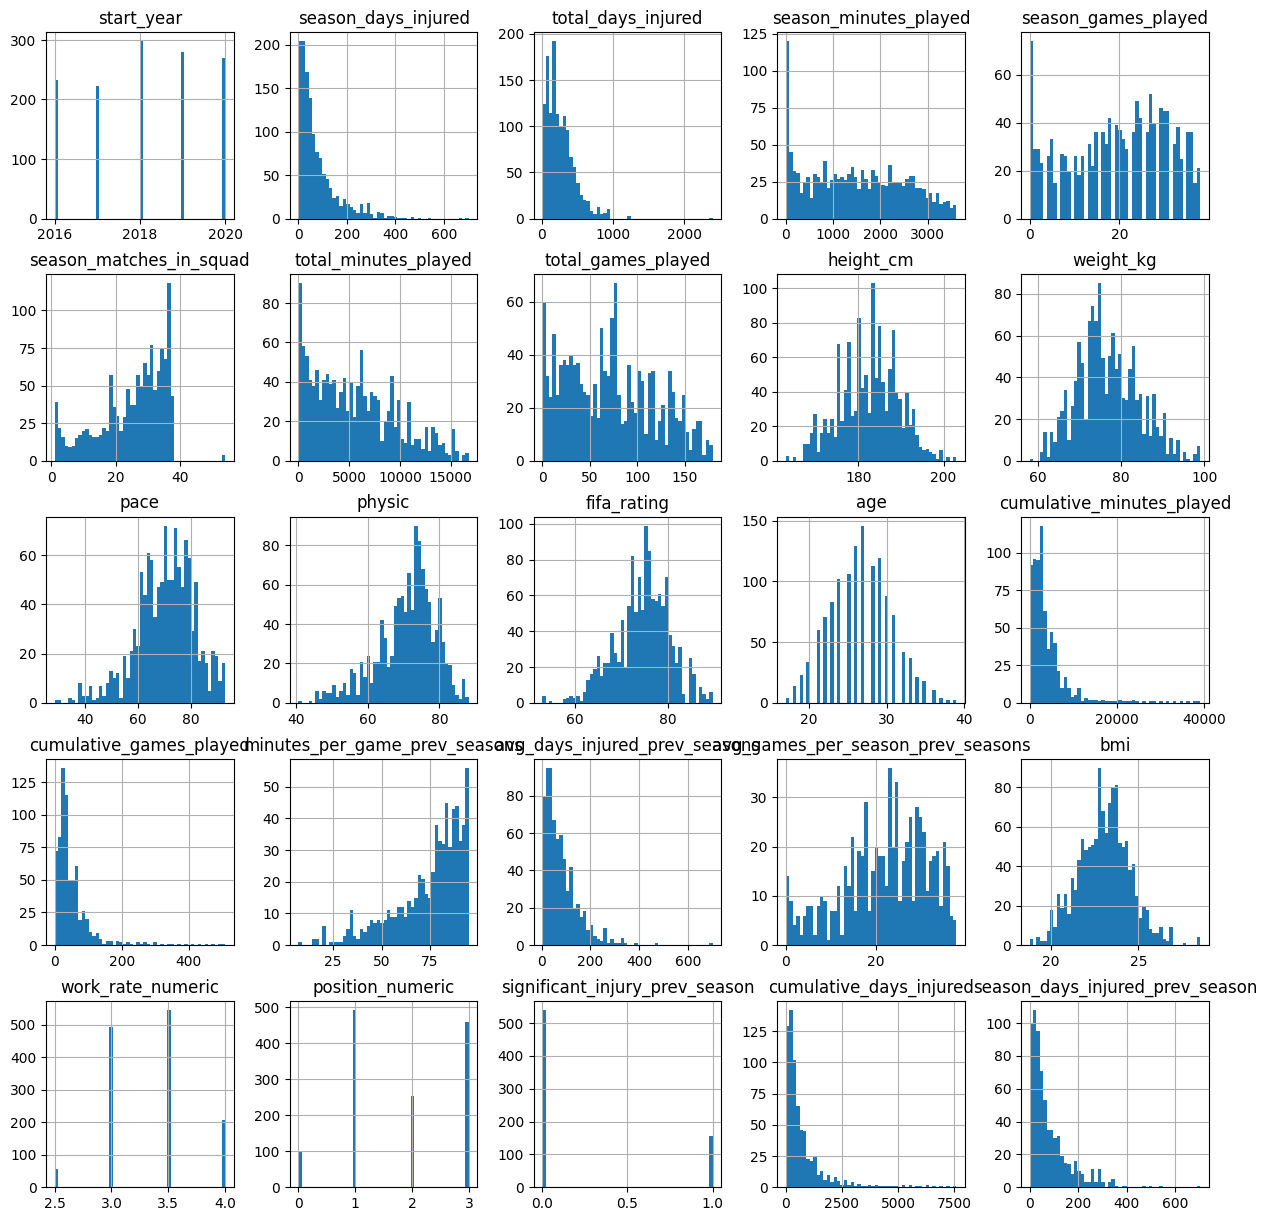

In [67]:
_ = df[df.columns].hist(bins=50, figsize=(15, 15)) 

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress, pearsonr

def plot_features_vs_target(df, x_features, y_feature):
    df_nonulls = df.dropna()

    # Generate line plots for each numerical column against the target feature
    plt.figure(figsize=(15, 25))
    for i, column in enumerate(x_features, 1):
        plt.subplot(5, 3, i)
        plt.plot(df_nonulls[column], df_nonulls[y_feature], marker='o', linestyle='', alpha=0.5)

        # Fit a line to the data
        m, b = np.polyfit(df_nonulls[column], df_nonulls[y_feature], 1)
        plt.plot(df_nonulls[column], m * df_nonulls[column] + b, color='r', linestyle='-', linewidth=2)

        # Calculate the R-squared value and correlation coefficient
        slope, intercept, r_value, p_value, std_err = linregress(df_nonulls[column], df_nonulls[y_feature])
        r_squared = r_value**2
        corr_coef, _ = pearsonr(df_nonulls[column], df_nonulls[y_feature])

        # Add R-squared value and correlation coefficient to the plot
        plt.text(0.05, 0.95, f'R^2: {r_squared:.2f}', transform=plt.gca().transAxes)
        plt.text(0.05, 0.90, f'Correlation: {corr_coef:.2f}', transform=plt.gca().transAxes)

        plt.xlabel(column)
        plt.ylabel(y_feature)

    plt.tight_layout()
    plt.show() 

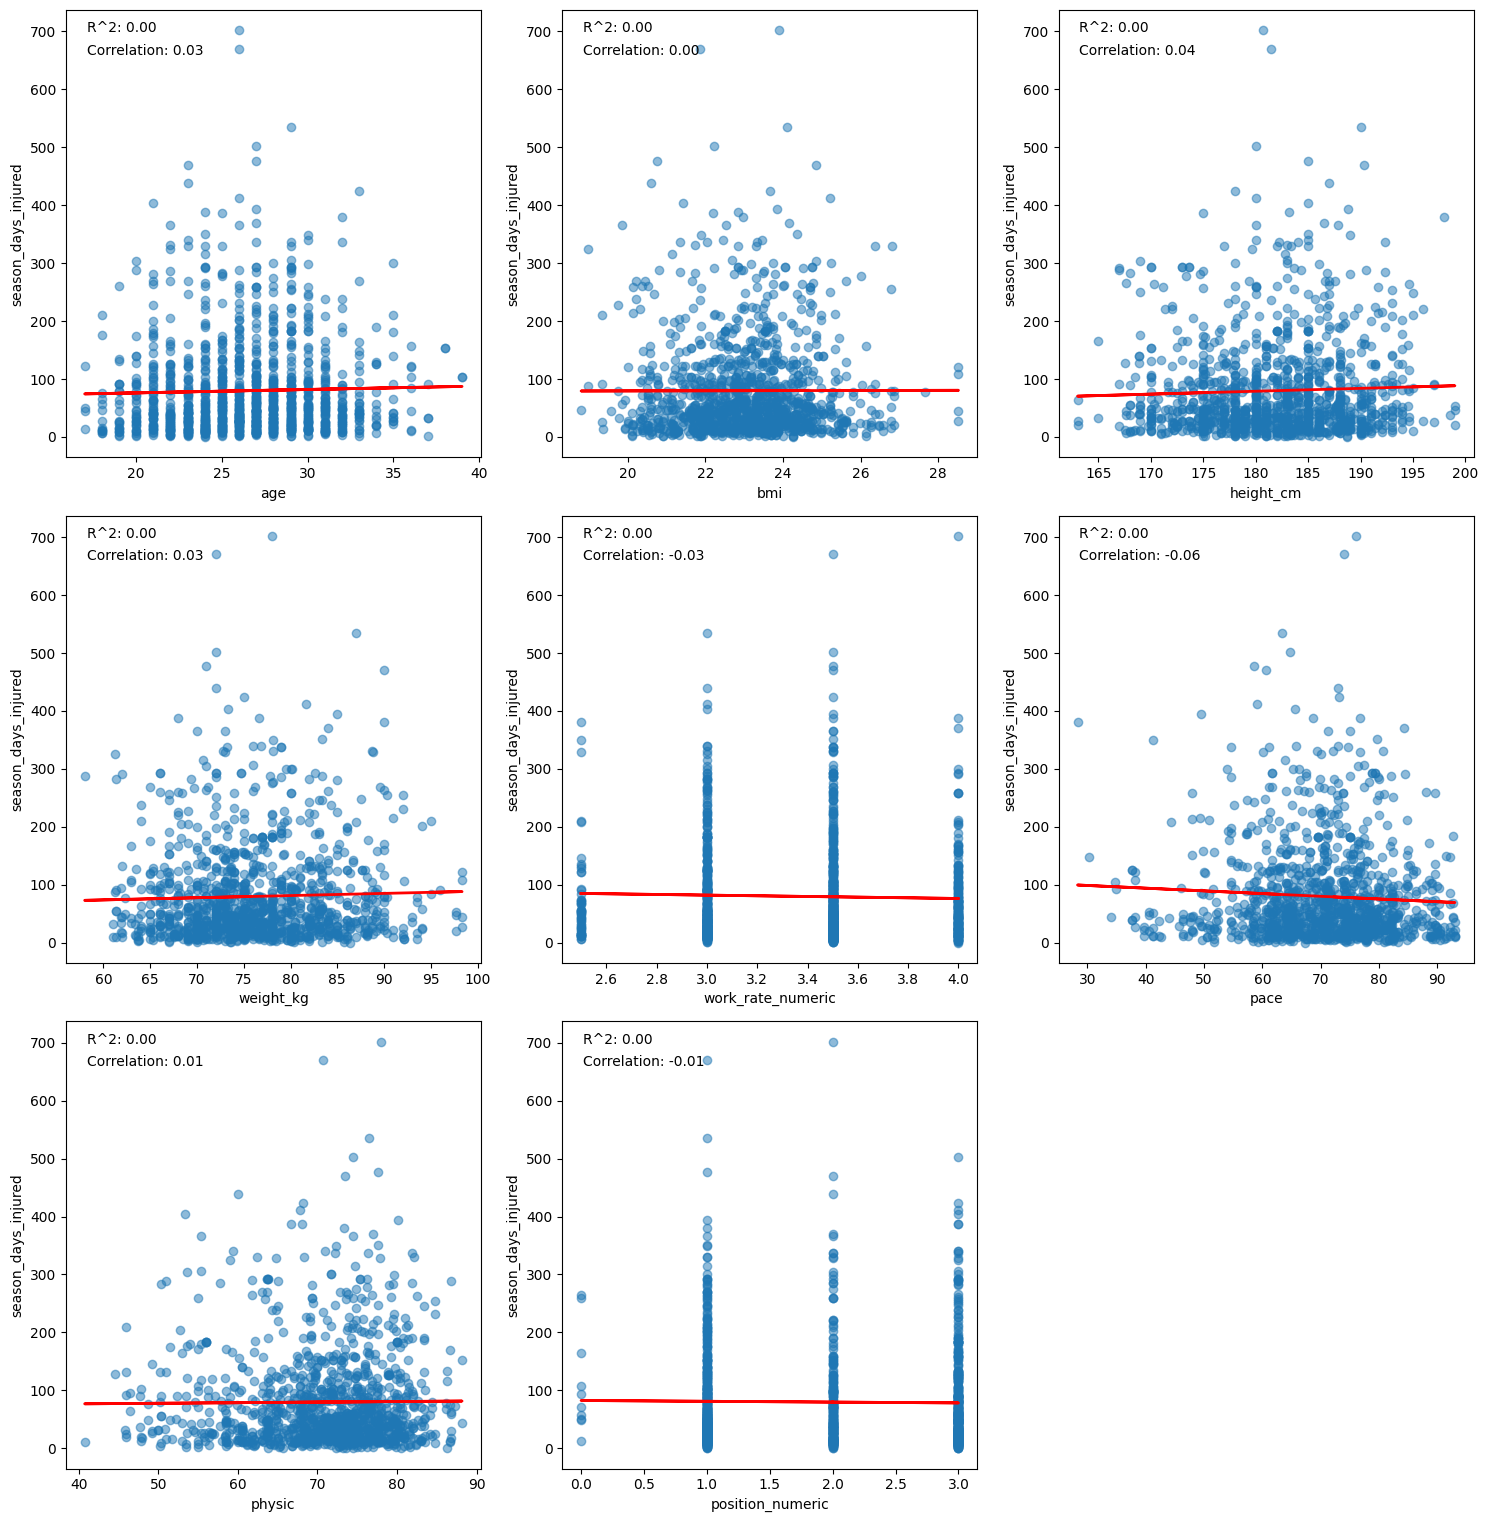

In [70]:
physical_features = ['age','bmi', 'height_cm', 'weight_kg', 'work_rate_numeric' ,'pace', 'physic',
                     'position_numeric']

plot_features_vs_target(df_physical, physical_features, 'season_days_injured')

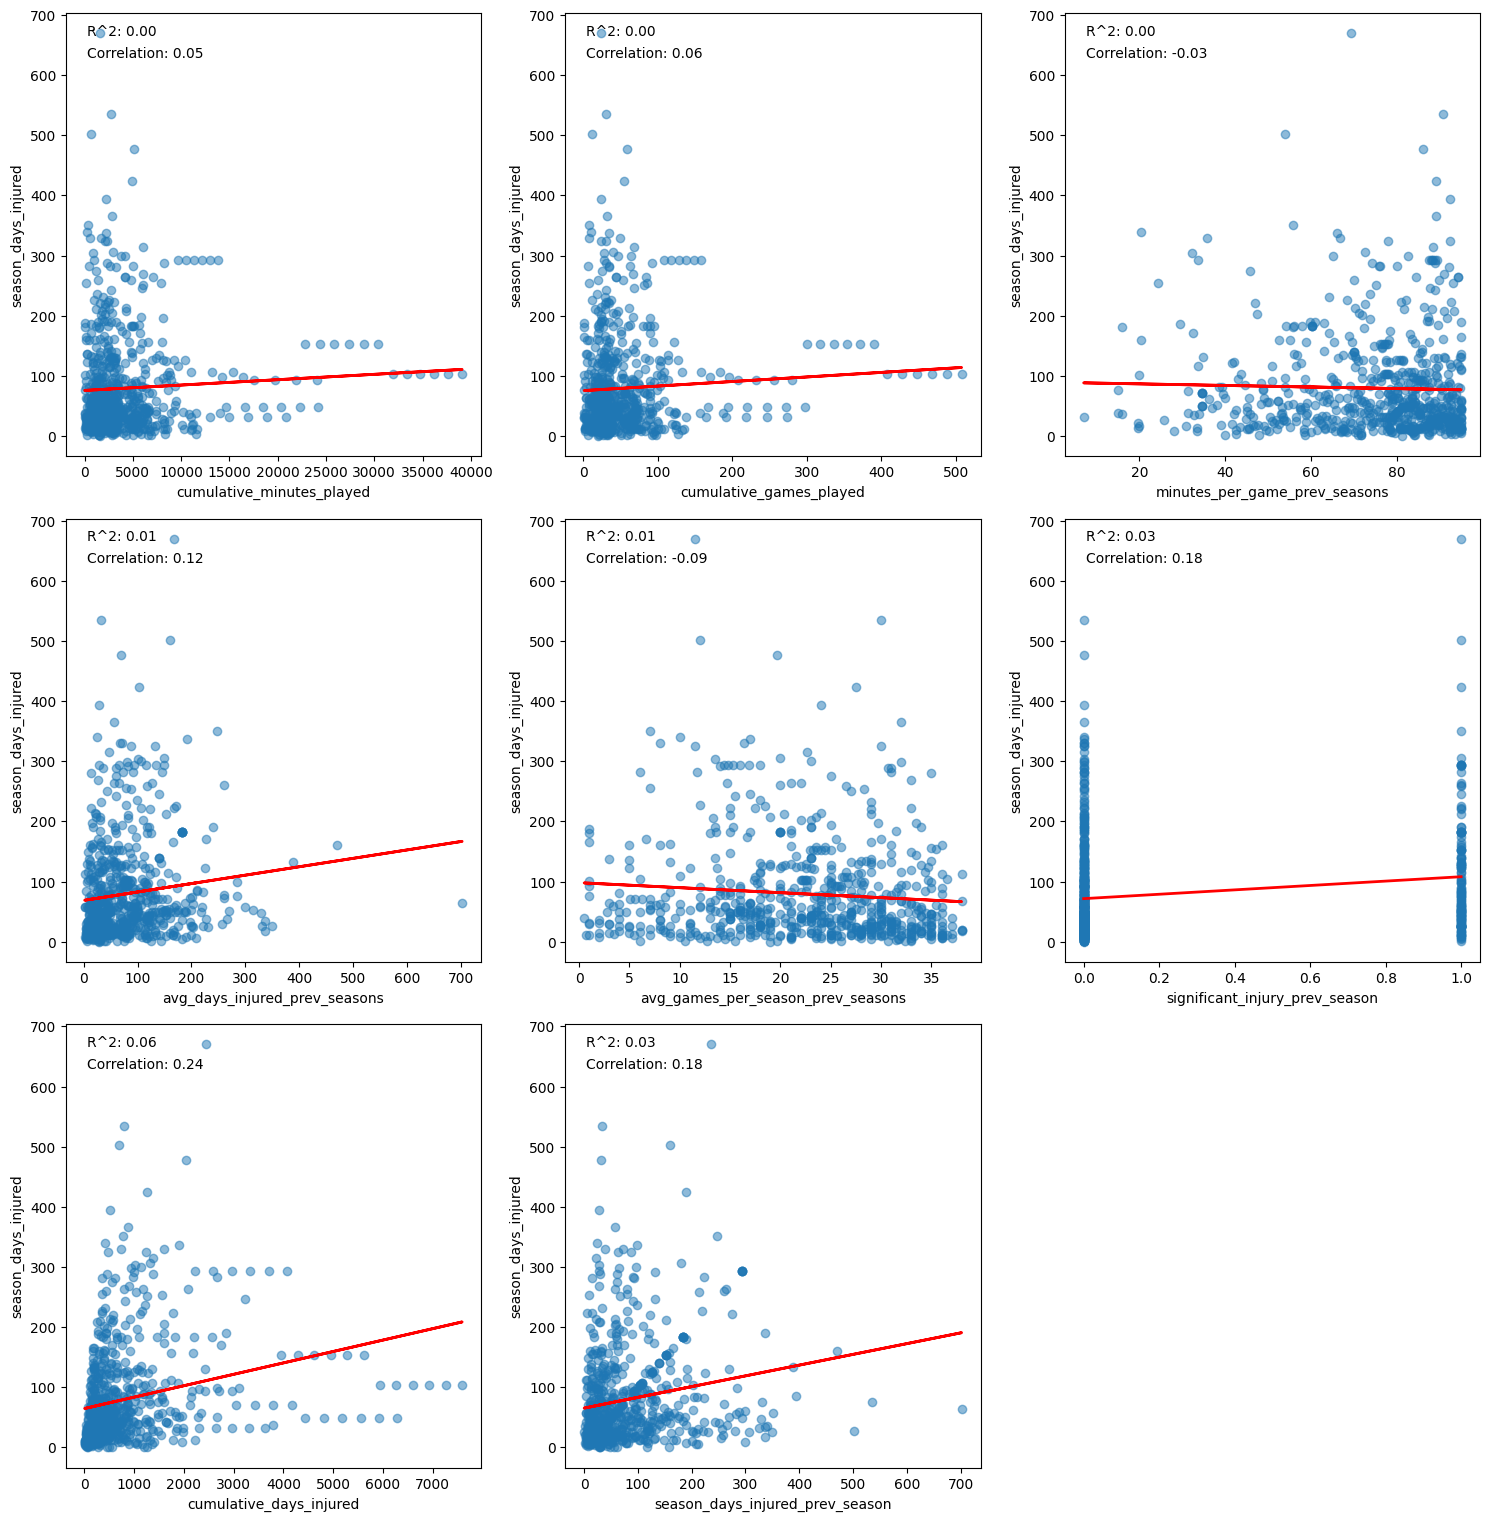

In [71]:
season_features = ['cumulative_minutes_played','cumulative_games_played',
                   'minutes_per_game_prev_seasons','avg_days_injured_prev_seasons', 'avg_games_per_season_prev_seasons', 
                  'significant_injury_prev_season', 'cumulative_days_injured','season_days_injured_prev_season']

plot_features_vs_target(df_season, season_features, 'season_days_injured')

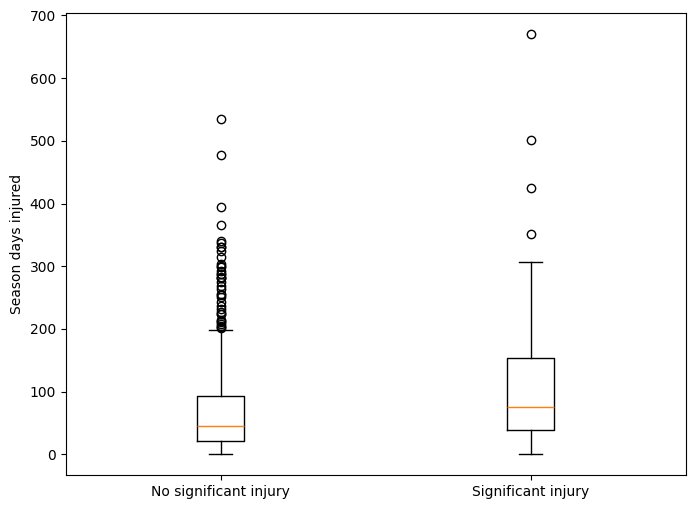

In [72]:
import matplotlib.pyplot as plt

df_nonulls = df.dropna()

plt.figure(figsize=(8, 6))
plt.boxplot([df_nonulls.loc[df_nonulls['significant_injury_prev_season'] == 0, 'season_days_injured'], 
             df_nonulls.loc[df_nonulls['significant_injury_prev_season'] == 1, 'season_days_injured']])
plt.xticks([1, 2], ['No significant injury', 'Significant injury'])
plt.ylabel('Season days injured')
plt.show()


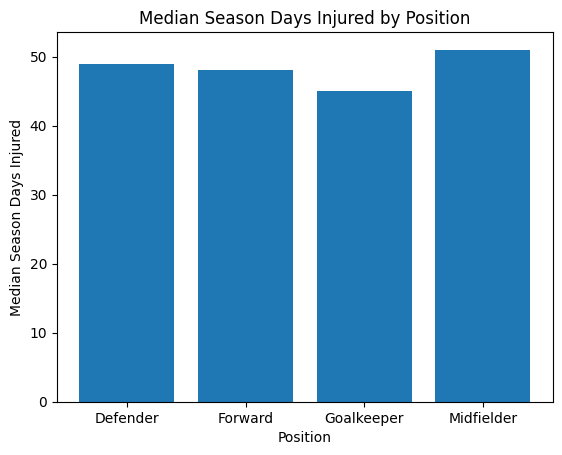

In [77]:
# See if/how position affects injury
import matplotlib.pyplot as plt

grouped = df.groupby('position')['season_days_injured'].median()

plt.bar(grouped.index, grouped.values)
plt.title('Median Season Days Injured by Position')
plt.xlabel('Position')
plt.ylabel('Median Season Days Injured')
plt.show()


It appears that physical features don't have strongest relationship with injury and that the features most predictive of injury are injury history from previous seasons

## Using Categorical Target Variable

In [81]:
# Analyse thresholds appropriate threshold for what is considered 'major injury'

def calculate_threshold_percentages(df, column_name, threshold_range):
    percentages = []
    for threshold in threshold_range:
        percentage_above_threshold = (df[column_name] > threshold).mean()
        percentages.append(percentage_above_threshold)
    return percentages

# Define the threshold range
threshold_range = np.arange(0, 210, 10)

# Call the function to calculate the percentages
percentages = calculate_threshold_percentages(df, 'season_days_injured', threshold_range)

# Print the percentages
for threshold, percentage in zip(threshold_range, percentages):
    print(f'{threshold:.1f}: {percentage:.2%}')


0.0: 99.92%
10.0: 91.62%
20.0: 78.09%
30.0: 66.87%
40.0: 57.26%
50.0: 48.58%
60.0: 42.20%
70.0: 37.51%
80.0: 33.21%
90.0: 29.36%
100.0: 25.44%
110.0: 22.60%
120.0: 20.91%
130.0: 17.91%
140.0: 16.14%
150.0: 15.30%
160.0: 13.14%
170.0: 12.22%
180.0: 11.38%
190.0: 9.92%
200.0: 9.22%


In [83]:
#injury_threshold defined in beginning of notebook
df['target_major_injury'] = (df['season_days_injured'] > injury_threshold).astype('category')

In [85]:
#Distribution of our target categorical variable
df['target_major_injury'].value_counts()

target_major_injury
False    1029
True      272
Name: count, dtype: int64

In [87]:
#Box plot function
def plot_features_vs_target_boxplot(df, x_features, y_feature):
    df_nonulls = df.dropna()

    # Generate box plots for each numerical column against the target feature
    plt.figure(figsize=(15, 15))
    for i, column in enumerate(x_features, 1):
        plt.subplot(3, 3, i)
        df_nonulls.boxplot(column=[column], by=y_feature, ax=plt.gca())
        plt.title(column)

    plt.tight_layout()
    plt.show() 


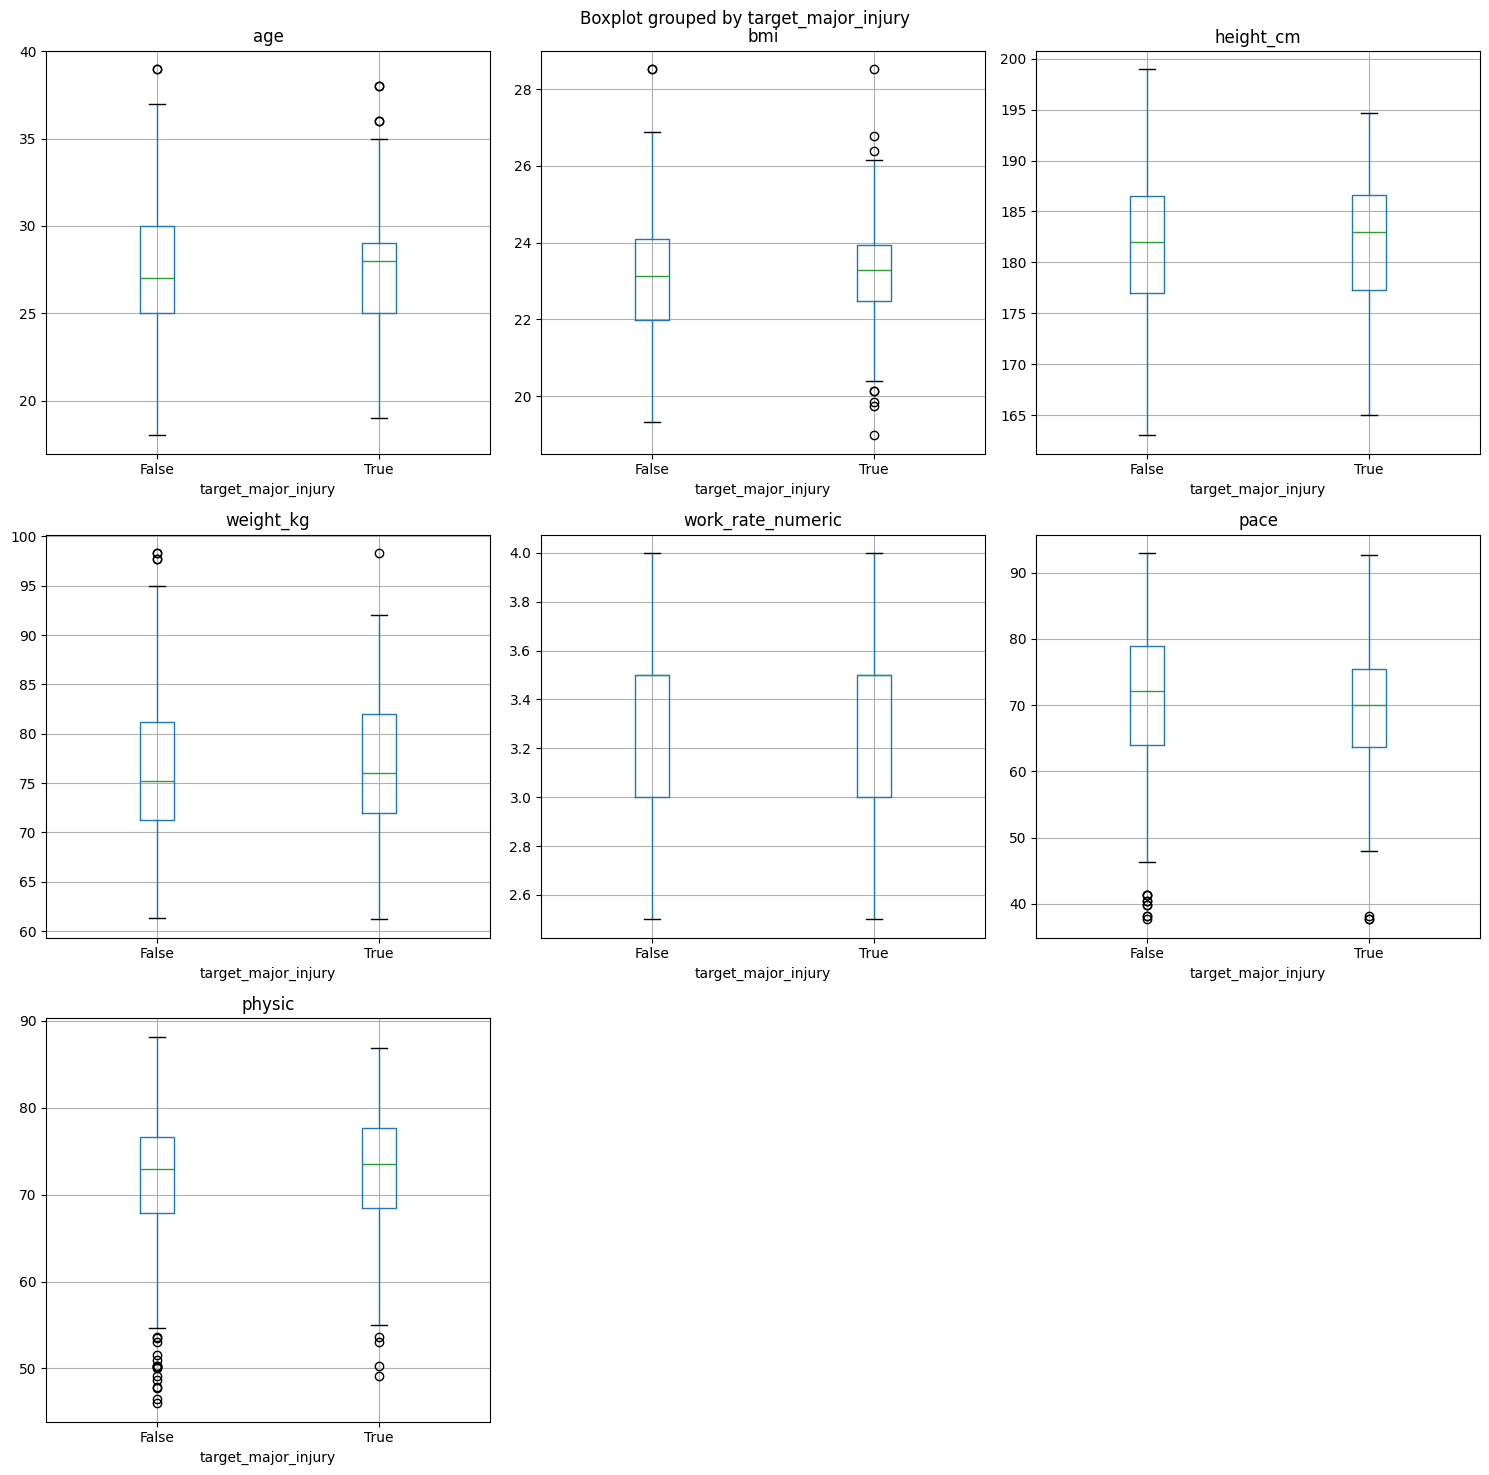

In [89]:
physical_features = ['age','bmi', 'height_cm', 'weight_kg', 'work_rate_numeric' ,'pace', 'physic']

plot_features_vs_target_boxplot(df, physical_features, 'target_major_injury')

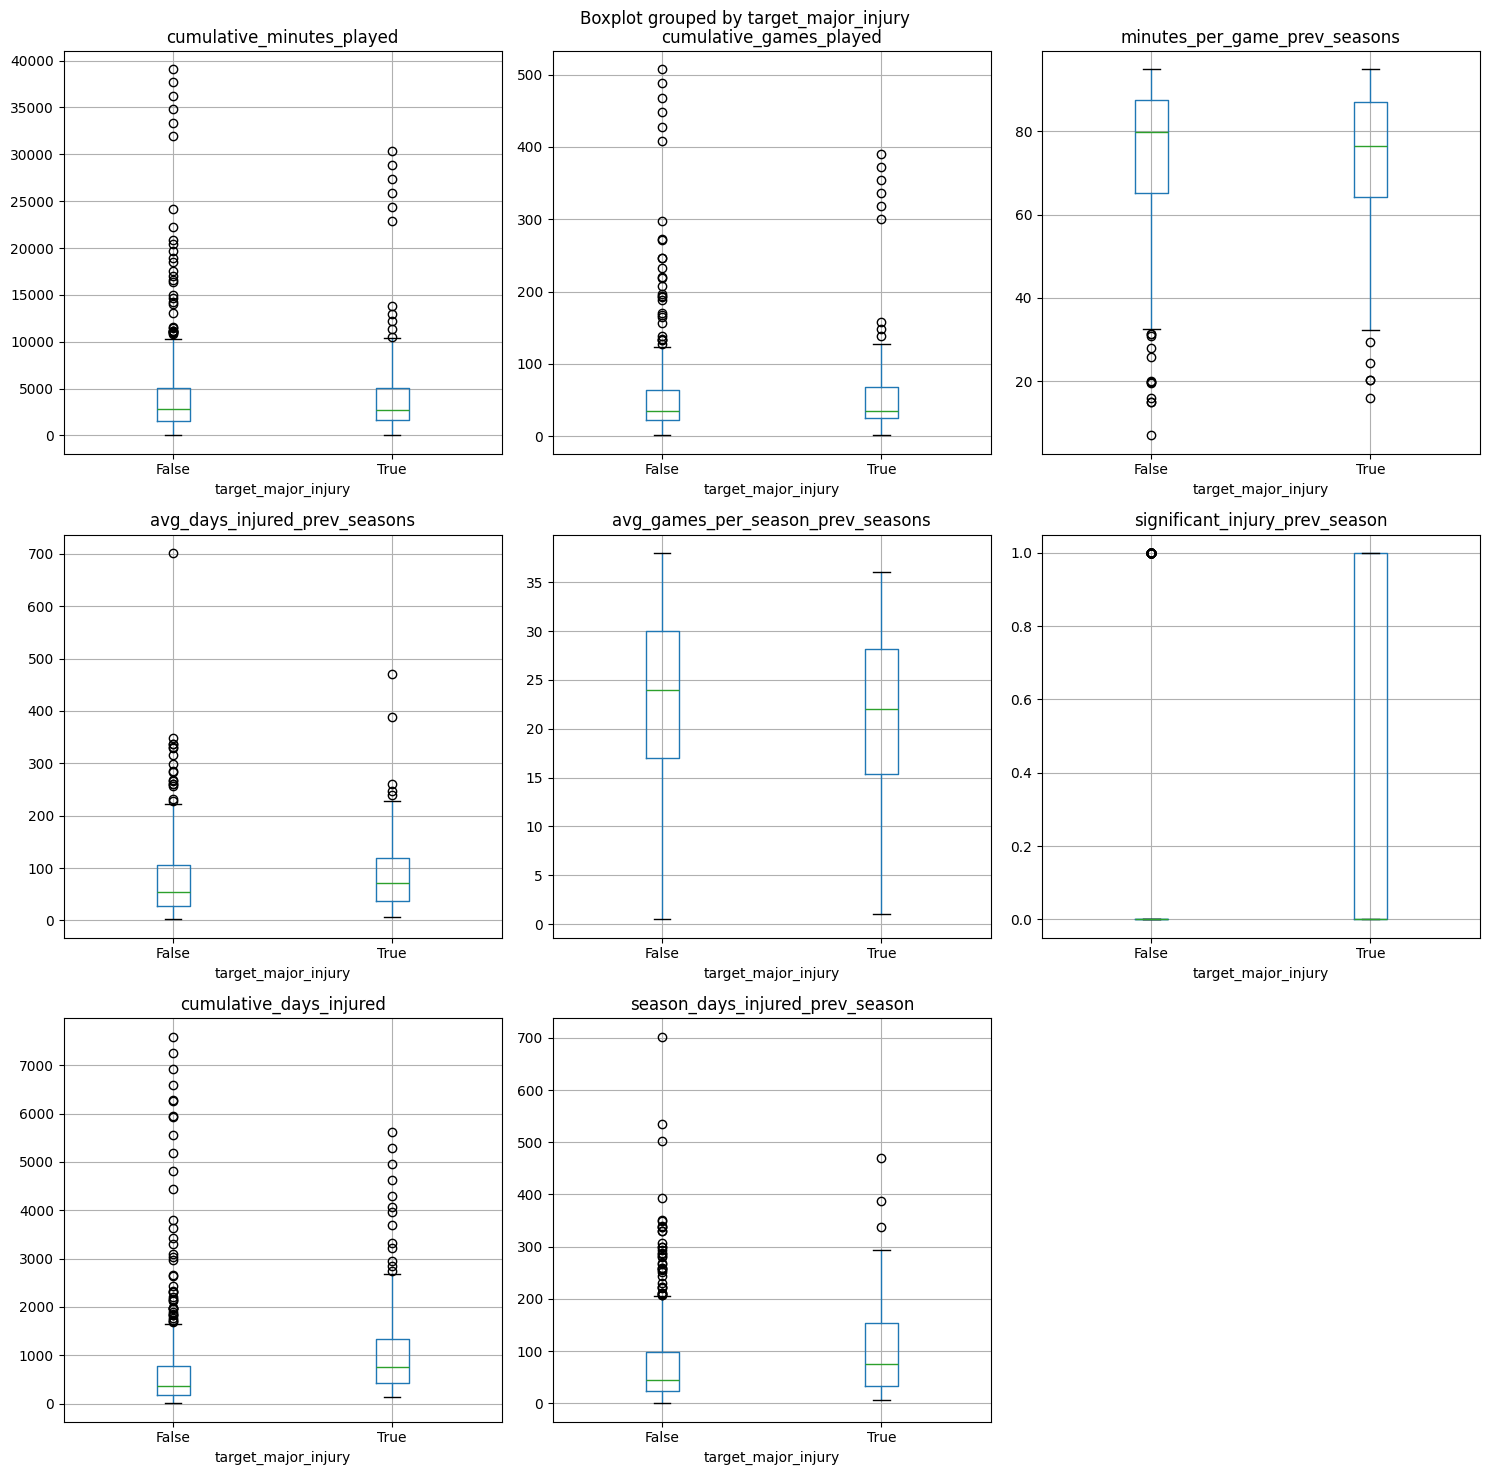

In [91]:
season_features = ['cumulative_minutes_played','cumulative_games_played',
                   'minutes_per_game_prev_seasons','avg_days_injured_prev_seasons', 'avg_games_per_season_prev_seasons', 
                  'significant_injury_prev_season', 'cumulative_days_injured','season_days_injured_prev_season']

plot_features_vs_target_boxplot(df, season_features, 'target_major_injury')

Again, we see the most start difference in the features related to previous season injuries. The expectation is that these features will have the heaviest weight in the Machine Learning Model

# Modelling

We will initially focus on target_major_injury (binary variable) as the target variable

## 1. Impute/drop nulls

In [97]:
#Drop nulls in key columns
cols_to_drop_nulls = [
    'cumulative_minutes_played', 'minutes_per_game_prev_seasons',
    'avg_days_injured_prev_seasons', 'significant_injury_prev_season',
    'cumulative_days_injured'
]

df = df.dropna(subset=cols_to_drop_nulls)

#Impute other nulls with mean (there are not many null values in pace/physic/position)
from sklearn.impute import SimpleImputer
mean_imputer = SimpleImputer(strategy='mean')
df[['pace', 'physic']] = mean_imputer.fit_transform(df[['pace', 'physic']])

mode_imputer = SimpleImputer(strategy='most_frequent')
df['position_numeric'] = mode_imputer.fit_transform(df['position_numeric'].values.reshape(-1, 1))


In [99]:
#Dataset for Y as a categorical variable
df_model_cat = df[['p_id2', 'start_year', 'height_cm', 'weight_kg', 'work_rate_numeric', 'pace',
       'physic', 'position_numeric', 'age', 'cumulative_minutes_played','minutes_per_game_prev_seasons',
       'avg_days_injured_prev_seasons', 'significant_injury_prev_season', 'cumulative_days_injured',
               'target_major_injury' ]]

#Dataset for Y as a numerical variable
df_model_num = df[['p_id2', 'start_year', 'height_cm', 'weight_kg', 'work_rate_numeric', 'pace',
       'physic', 'position_numeric', 'age', 'cumulative_minutes_played','minutes_per_game_prev_seasons',
       'avg_days_injured_prev_seasons', 'significant_injury_prev_season', 'cumulative_days_injured',
                   'season_days_injured']]

In [101]:
print('Total rows:', df_model_cat.shape[0])

Total rows: 685


## 2. Train/Test Split + Oversampling

In [104]:
from sklearn.model_selection import train_test_split

X = df_model_cat.drop(['target_major_injury', 'p_id2', 'start_year'], axis=1)
y = df_model_cat['target_major_injury']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [110]:
!pip install imbalanced-learn


In [112]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Convert non-numeric labels to numeric values (required for SMOTE)
le = LabelEncoder()
y_train = le.fit_transform(y_train)

# Apply SMOTE oversampling
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

Major injuries only accounts for 20% of data, let's oversample it accordingly using 'SMOTE' (Synthetic Minority Oversampling Technique)

## 3. Feature Scaling

In [114]:
from sklearn.preprocessing import StandardScaler

X_train_scaled = X_train.copy() #Maintain an unscaled copy (for us to use in XG Boost Feature Selection later)
X_test_scaled = X_test.copy() #Maintain an unscaled copy (for us to use in XG Boost Feature Selection later)

scaler = StandardScaler()

continuous_features = [
    'height_cm', 'weight_kg', 'work_rate_numeric', 'pace', 'physic',
    'age', 'cumulative_minutes_played', 'minutes_per_game_prev_seasons',
    'avg_days_injured_prev_seasons', 'cumulative_days_injured'
]

X_train_scaled[continuous_features] = scaler.fit_transform(X_train_scaled[continuous_features])
X_test_scaled[continuous_features] = scaler.transform(X_test_scaled[continuous_features])


## 4. Feature selection

* We'll use Recursive Feature Elimination to consider interactions in the data
* Although generally computationally expensive, our dataset is relatively small so shouldn't be an issue

In [118]:
# Convert target variable to integer
y_train = y_train.astype(int)
y_test = y_test.astype(int)


from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

base_estimator = LogisticRegression(random_state=42)

rfe = RFECV(base_estimator, step=1, cv=5, scoring='roc_auc')
rfe.fit(X_train_scaled, y_train)

selected_features = X_train_scaled.columns[rfe.support_]

X_train_rfe_scaled = rfe.transform(X_train_scaled)
X_test_rfe_scaled = rfe.transform(X_test_scaled)

In [120]:
#See final selected features
selected_features = X_train_scaled.columns[rfe.support_]
print("Selected features:", selected_features)

Selected features: Index(['pace', 'cumulative_minutes_played', 'avg_days_injured_prev_seasons',
       'significant_injury_prev_season', 'cumulative_days_injured'],
      dtype='object')


In [122]:
# Fit  base estimator with  selected features
base_estimator.fit(X_train_rfe_scaled, y_train)

# Extract  feature importance scores
if hasattr(base_estimator, "coef_"):
    feature_importance_scores = base_estimator.coef_[0]
elif hasattr(base_estimator, "feature_importances_"):
    feature_importance_scores = base_estimator.feature_importances_

print("Feature importance scores:", dict(zip(selected_features, feature_importance_scores)))


Feature importance scores: {'pace': np.float64(-0.32201098465150263), 'cumulative_minutes_played': np.float64(-1.0145411157844273), 'avg_days_injured_prev_seasons': np.float64(-0.7344947368541866), 'significant_injury_prev_season': np.float64(1.572797828981855), 'cumulative_days_injured': np.float64(1.0365144057448208)}


## 5. Model Selection

### 5.1 Logistic Regression

In [126]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)

model.fit(X_train_rfe_scaled, y_train)

LogisticRegression(random_state=42)

In [128]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = model.predict(X_test_rfe_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))


Accuracy: 0.6699029126213593
Precision: 0.2647058823529412
Recall: 0.5
F1 Score: 0.34615384615384615
ROC AUC Score: 0.6029411764705881


Poor ROC AUC score. Let's try other models to try and account for interactions, categorical variables better

### 5.2 XGBoost Model

#### 5.2.1 Without Recursive Feature Elimination

In [137]:
pip install xgboost==1.7.6


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 2.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.0.0
    Uninstalling xgboost-3.0.0:
      Successfully uninstalled xgboost-3.0.0
Note: you may need to restart the kernel to use updated packages.


In [145]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

# Initialize the XGBoost classifier with eval_metric inside
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    use_label_encoder=False,
    eval_metric='auc'  # <-- moved here
)

# Fit the model
xgb_clf.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Make predictions
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC score:", roc_auc)


ROC AUC score: 0.6700980392156862


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:47:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  if cb_container.before_iteration(bst, i, dtrain, evals):


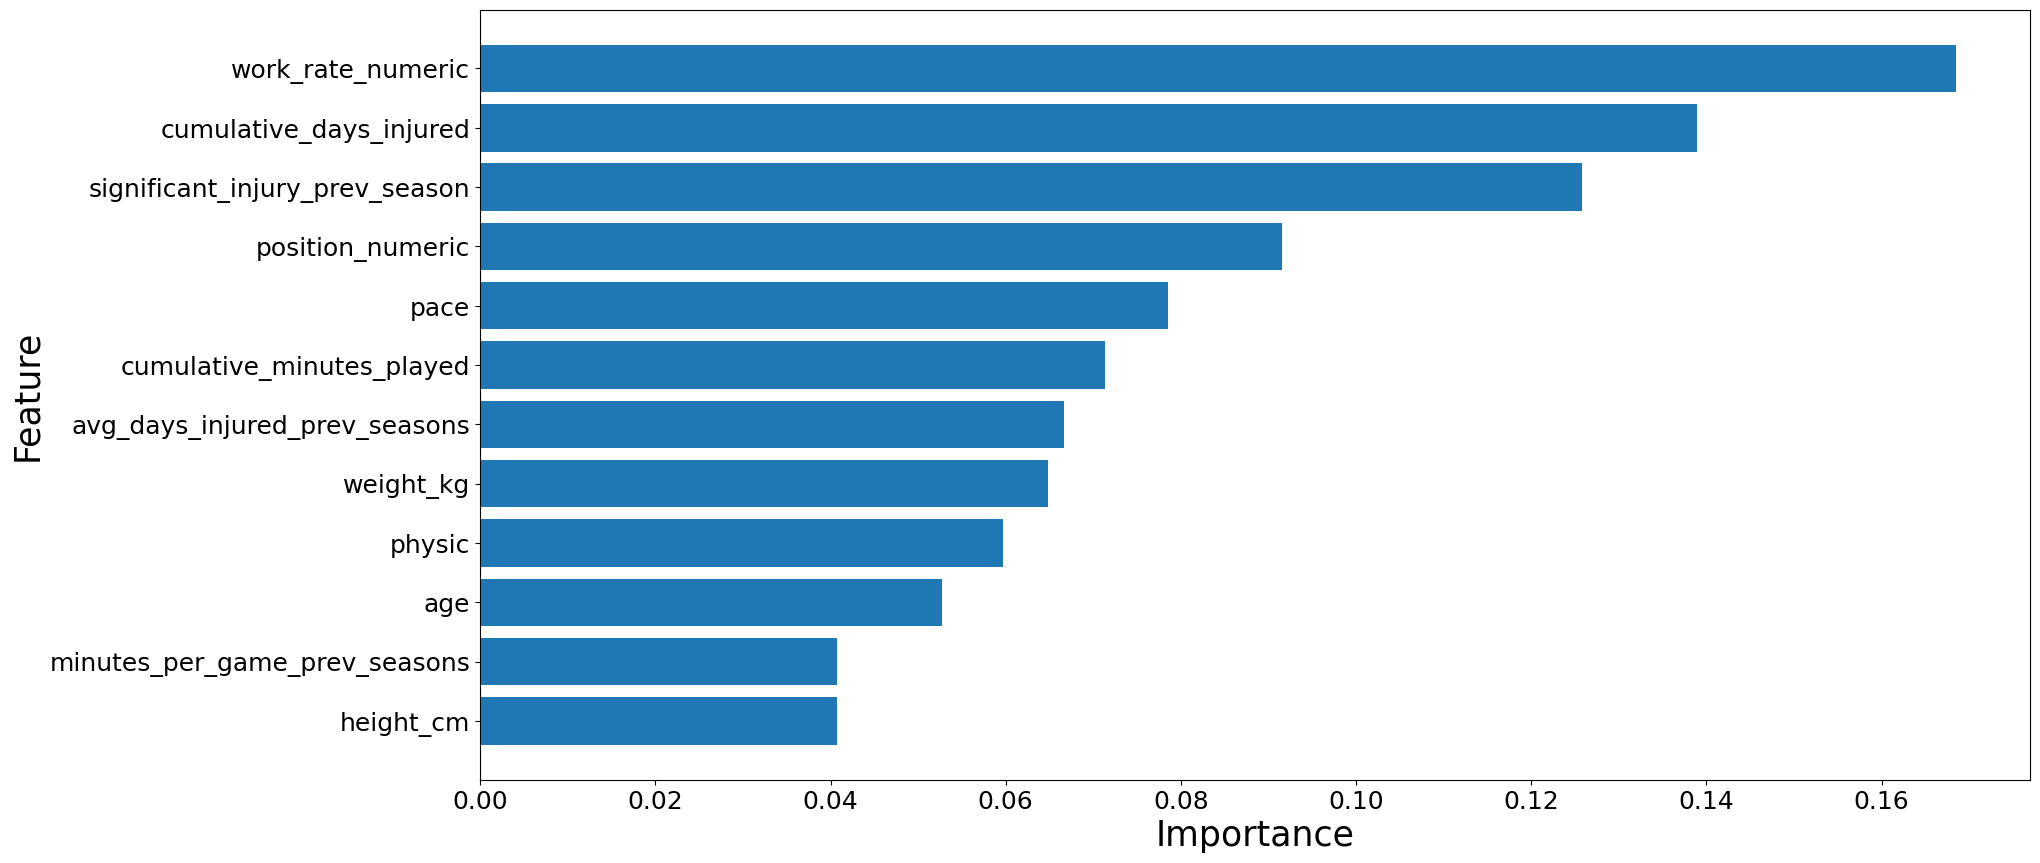

In [147]:
# Extract feature importances
importances = xgb_clf.feature_importances_

# Create dictionary of feature importances
importances_dict = dict(zip(X_train.columns, importances))

# Sort dictionary by descending importance
importances_dict_sorted = dict(sorted(importances_dict.items(), key=lambda item: item[1]))

# Set font size
plt.rcParams.update({'font.size': 10})

# Plot feature importances
plt.figure(figsize=(20, 10))
plt.barh(list(importances_dict_sorted.keys()), list(importances_dict_sorted.values()))
plt.xlabel("Importance", fontsize=25)
plt.ylabel("Feature", fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


#### 5.2.2 With Recursive Feature Elimination

In [149]:
# First we need to re-do RFE step with XGBoost as the base estimator, rather than logistic regression

# Encode labels as integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Create XGBClassifier with use_label_encoder=False and explicit eval_metric
base_estimator = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

rfe = RFECV(base_estimator, step=1, cv=5, scoring='roc_auc')
rfe.fit(X_train, y_train_encoded)

selected_features = X_train.columns[rfe.support_]

X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:47:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  if cb_container.before_iteration(bst, i, dtrain, evals):
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:47:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  if cb_container.before_iteration(bst, i, dtrain, evals):
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:47:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  if cb_container.before_iteration(bst, i, dtrain, evals):
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:47:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } ar

In [151]:
#See final selected features
selected_features = X_train.columns[rfe.support_]
print("Selected features:", selected_features)

Selected features: Index(['height_cm', 'weight_kg', 'work_rate_numeric', 'pace', 'physic',
       'position_numeric', 'age', 'cumulative_minutes_played',
       'minutes_per_game_prev_seasons', 'avg_days_injured_prev_seasons',
       'significant_injury_prev_season', 'cumulative_days_injured'],
      dtype='object')


In [153]:
# Fit  base estimator with  selected features
base_estimator.fit(X_train_rfe, y_train)

# Extract  feature importance scores
if hasattr(base_estimator, "coef_"):
    feature_importance_scores = base_estimator.coef_[0]
elif hasattr(base_estimator, "feature_importances_"):
    feature_importance_scores = base_estimator.feature_importances_

print("Feature importance scores:", dict(zip(selected_features, feature_importance_scores)))


Feature importance scores: {'height_cm': np.float32(0.05330998), 'weight_kg': np.float32(0.05818598), 'work_rate_numeric': np.float32(0.20291156), 'pace': np.float32(0.07874721), 'physic': np.float32(0.02841521), 'position_numeric': np.float32(0.102808274), 'age': np.float32(0.042284723), 'cumulative_minutes_played': np.float32(0.07054105), 'minutes_per_game_prev_seasons': np.float32(0.037194345), 'avg_days_injured_prev_seasons': np.float32(0.06774847), 'significant_injury_prev_season': np.float32(0.13538869), 'cumulative_days_injured': np.float32(0.12246442)}


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:48:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  if cb_container.before_iteration(bst, i, dtrain, evals):


In [157]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

# Initialize the XGBoost classifier with eval_metric moved to constructor
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    use_label_encoder=False,
    booster='gbtree',
    eval_metric='auc'  # <-- moved here
)

# Fit the model to the training data
xgb_clf.fit(X_train_rfe, y_train)

# Make predictions on the test set
y_pred_proba = xgb_clf.predict_proba(X_test_rfe)[:, 1]

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC score:", roc_auc)


ROC AUC score: 0.6700980392156862


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:48:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  if cb_container.before_iteration(bst, i, dtrain, evals):


Feature importances: {'height_cm': np.float32(0.040745992), 'weight_kg': np.float32(0.06480313), 'work_rate_numeric': np.float32(0.16852798), 'pace': np.float32(0.0785661), 'physic': np.float32(0.0596803), 'position_numeric': np.float32(0.09153333), 'age': np.float32(0.05276555), 'cumulative_minutes_played': np.float32(0.07128716), 'minutes_per_game_prev_seasons': np.float32(0.040780477), 'avg_days_injured_prev_seasons': np.float32(0.066612996), 'significant_injury_prev_season': np.float32(0.125746), 'cumulative_days_injured': np.float32(0.13895097)}


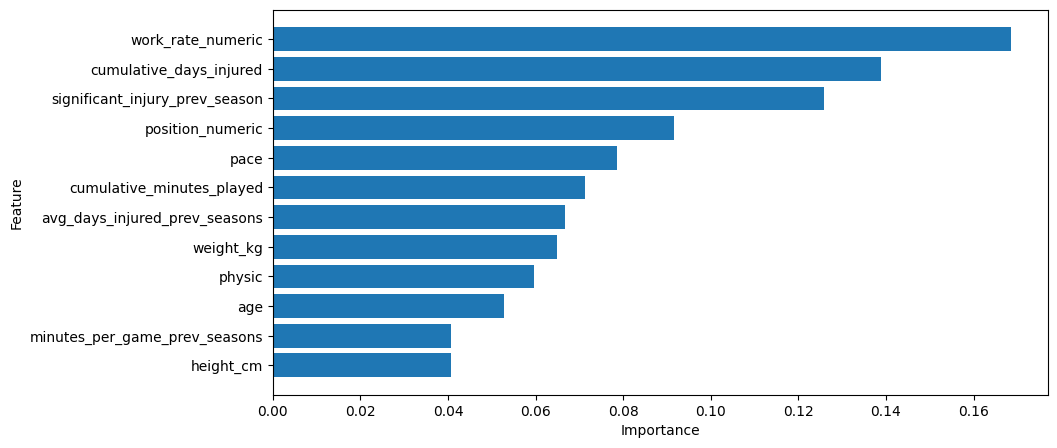

In [159]:
# Extract feature importances
importances = xgb_clf.feature_importances_

# Display feature importances
feature_importances = dict(zip(selected_features, importances))
print("Feature importances:", feature_importances)

# Sort feature importances
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Plot feature importances
plt.figure(figsize=(10, 5))
plt.barh([item[0] for item in sorted_features], [item[1] for item in sorted_features])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest importance at the top
plt.show()


* ROC AUC score is slightly higher with Recursive Feature Elimination

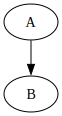

In [164]:
import graphviz
graphviz.Source('digraph G { A -> B }')


/opt/anaconda3/lib/python3.12/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  -------


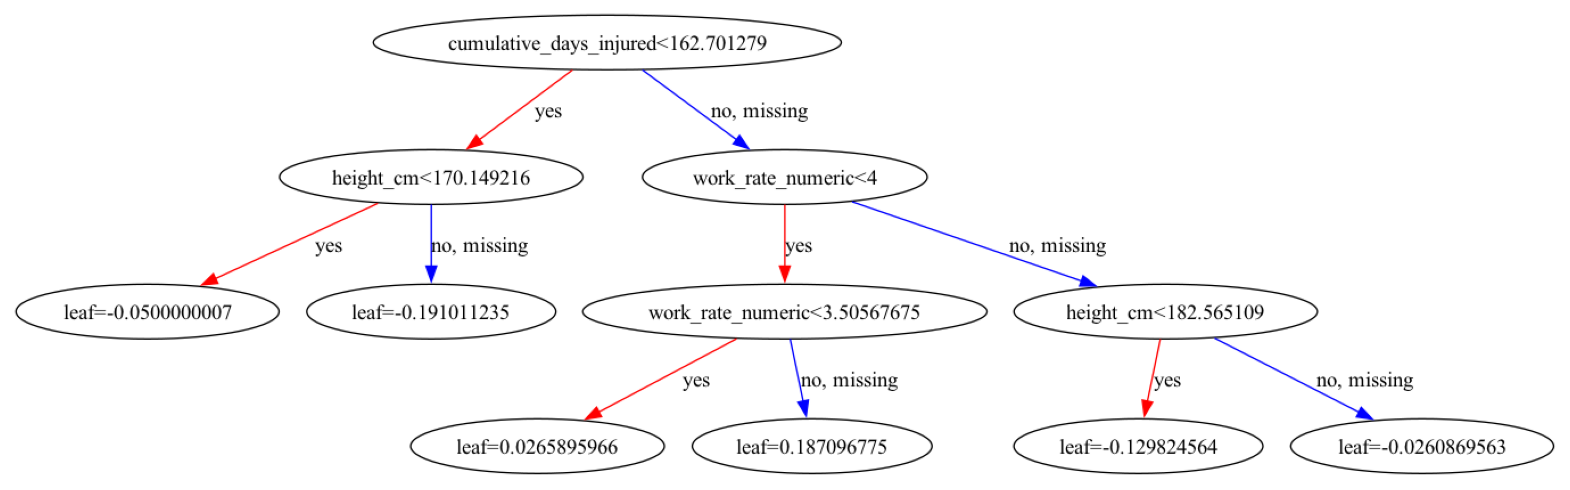

In [166]:
import matplotlib.pyplot as plt
from xgboost import to_graphviz
import tempfile

# Get the feature names and their corresponding indexes
feature_names = list(selected_features)
feature_dict = {f"f{i}": name for i, name in enumerate(feature_names)}

# Create a temporary file containing the feature mapping
with tempfile.NamedTemporaryFile(mode="w", delete=False) as fmap_file:
    for i, name in enumerate(feature_names):
        fmap_file.write(f"{i}\t{name}\tq\n")
    fmap_file_name = fmap_file.name

# Plot the first tree in the XGBoost model with actual feature names
graph = to_graphviz(xgb_clf, fmap=fmap_file_name, num_trees=0)

# Save the graph as an image file and display it
graph.render('tree', format='png', cleanup=True)
img = plt.imread('tree.png')
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(img)
ax.axis('off')
plt.show()


## 6. Hyperparameter Tuning & Cross Validation

* Let's optimize the model. We'll use a grid search to tune our hyperparameters
* Although it can be computationally expensive, our relatively small dataset should make it managable
* We'll cross-validate to reduce risk of over-fitting

In [172]:
pip install --upgrade xgboost


  Using cached xgboost-3.0.0-py3-none-macosx_12_0_arm64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.0-py3-none-macosx_12_0_arm64.whl (2.0 MB)
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.7.6
    Uninstalling xgboost-1.7.6:
      Successfully uninstalled xgboost-1.7.6
Note: you may need to restart the kernel to use updated packages.


In [176]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the parameter grid for hyperparameter tuning
param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 5],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "eval_metric": ['auc']  # Add eval_metric as a parameter for GridSearchCV
}

# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False)

# Initialize GridSearchCV object
grid_search = GridSearchCV(
    xgb_clf, param_grid, scoring="roc_auc", n_jobs=-1, cv=5, verbose=1
)

# Fit GridSearchCV object to training data (without RFE)
grid_search.fit(X_train_rfe, y_train)

# Print best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Print best ROC AUC score
print("Best ROC AUC score:", grid_search.best_score_)


Fitting 5 folds for each of 729 candidates, totalling 3645 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:55:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:55:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:55:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:55:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Best hyperparameters: {'colsample_bytree': 1.0, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Best ROC AUC score: 0.9515471185202842


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:56:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  if cb_container.before_iteration(bst, i, dtrain, evals):


In [180]:
from sklearn.metrics import roc_auc_score
import xgboost as xgb

# Apply new hyperparameters
best_params = grid_search.best_params_

# Define the parameters including eval_metric
params = {**best_params, 'eval_metric': 'auc'}

# Train the final model with the best hyperparameters
final_xgb_clf = xgb.XGBClassifier(**params, random_state=42, use_label_encoder=False)
final_xgb_clf.fit(X_train_rfe, y_train)

# Make predictions on the test set
y_pred_proba_final = final_xgb_clf.predict_proba(X_test_rfe)[:, 1]

# Compute ROC AUC score
roc_auc_final = roc_auc_score(y_test, y_pred_proba_final)
print("Final ROC AUC score:", roc_auc_final)


Final ROC AUC score: 0.6665032679738562


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:56:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  if cb_container.before_iteration(bst, i, dtrain, evals):


## 7. Evaluation

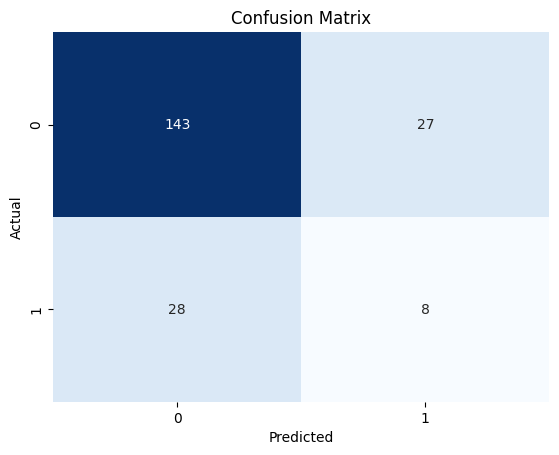

In [183]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = final_xgb_clf.predict(X_test_rfe)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


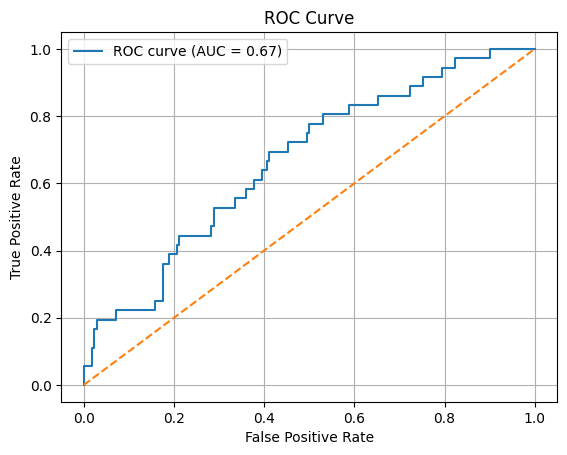

In [185]:
#ROC curve

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_final)

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_final:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


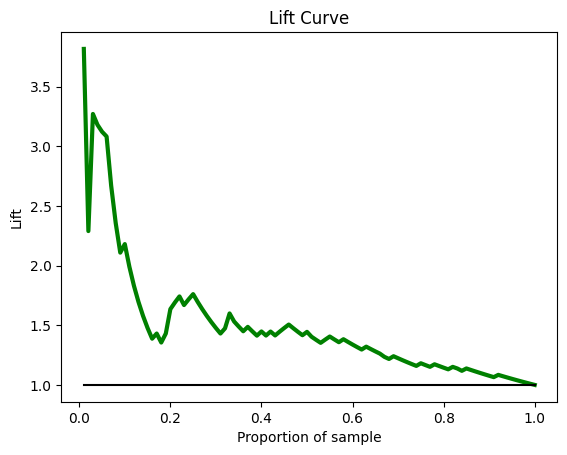

In [187]:
#LIFT Plot

#Function below from: https://howtolearnmachinelearning.com/code-snippets/lift-curve-code-snippet/
# Function that plots a Lift Curve using the real label values of a dataset and the probability predictions of a Machine Learning Algorithm/model
# @Params:
# y_val: real labels of the data
# y_pred: probability predictions for such data
# step: how big we want the steps in the percentiles to be

# imports
import numpy as np
import pandas as pd

def plot_lift_curve(y_val, y_pred, step=0.01):
    
    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)
    
    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []
    
    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number 
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
           
   #Plot the figure
    fig, axis = plt.subplots()
    fig.figsize = (40,40)
    axis.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    plt.title('Lift Curve')
    plt.show()
    
plot_lift_curve(y_test, y_pred_proba_final, step=0.01)

In [189]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba_final)
    
    print("Accuracy: {:.2f}%".format(accuracy*100))
    print("Precision: {:.2f}%".format(precision*100))
    print("Recall: {:.2f}%".format(recall*100))
    print("F1 score: {:.2f}%".format(f1*100))
    print("AUC-ROC score: {:.2f}%".format(auc_roc*100))

evaluate_model(y_test, y_pred)


Accuracy: 73.30%
Precision: 22.86%
Recall: 22.22%
F1 score: 22.54%
AUC-ROC score: 66.65%
